#Import dataset

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from datetime import datetime
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

In [15]:
df = pd.read_csv('synthetic_dataset_1000.csv')
df.head()
df = df.loc[:, ~df.columns.duplicated()]
print("Columns:", df.columns.tolist())
print(df.head())

Columns: ['CustomerID', 'Age', 'Gender', 'Region', 'MonthlyIncome', 'SpendingScore', 'SubscriptionType', 'TenureMonths', 'Churn', 'PurchaseAmount', 'TransactionDate']
  CustomerID  Age  Gender Region  MonthlyIncome  SpendingScore  \
0   CUST0001   56    Male  North           6443             76   
1   CUST0002   69    Male  South           8770             45   
2   CUST0003   46    Male   West          14917             67   
3   CUST0004   32  Female  North          11732             86   
4   CUST0005   60    Male   West           8099             66   

  SubscriptionType  TenureMonths Churn  PurchaseAmount TransactionDate  
0         Standard            35    No         3379.85      2024-05-18  
1         Standard            48   Yes         1233.27      2023-08-30  
2         Standard            18   Yes         1293.50      2025-01-19  
3            Basic            16    No         1599.63      2024-01-27  
4            Basic            55   Yes          412.06      2025-08-15 

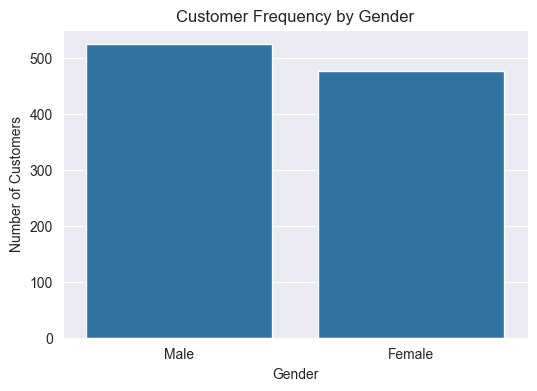

In [16]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Gender")
plt.title("Customer Frequency by Gender")
plt.xlabel("Gender")
plt.ylabel("Number of Customers")
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_9060\2254761803.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="IncomeBracket", y="SpendingScore", palette="Set2")


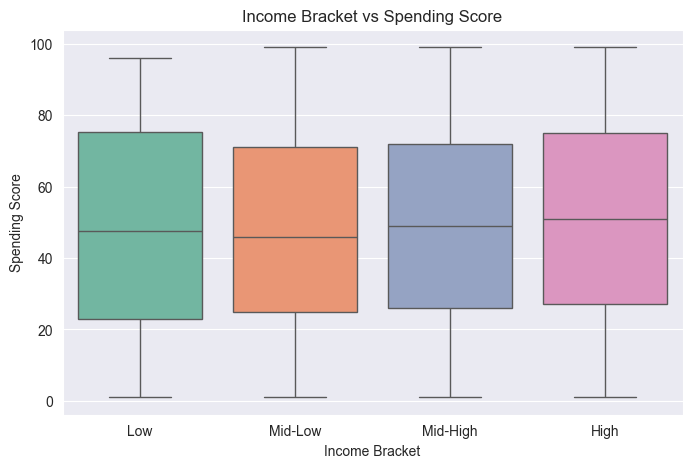

In [17]:
bins = [0, 3000, 6000, 10000, 20000]
labels = ["Low", "Mid-Low", "Mid-High", "High"]
df["IncomeBracket"] = pd.cut(df["MonthlyIncome"], bins=bins, labels=labels)

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="IncomeBracket", y="SpendingScore", palette="Set2")
plt.title("Income Bracket vs Spending Score")
plt.xlabel("Income Bracket")
plt.ylabel("Spending Score")
plt.show()

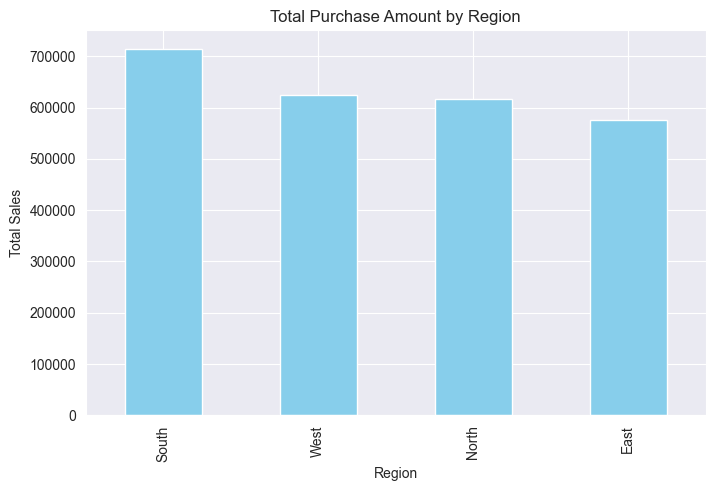

In [18]:
region_sales = df.groupby("Region")["PurchaseAmount"].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
region_sales.plot(kind="bar", color="skyblue")
plt.title("Total Purchase Amount by Region")
plt.xlabel("Region")
plt.ylabel("Total Sales")
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_9060\3831176488.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_income = df.groupby("IncomeBracket")["Churn"].value_counts(normalize=True).unstack()


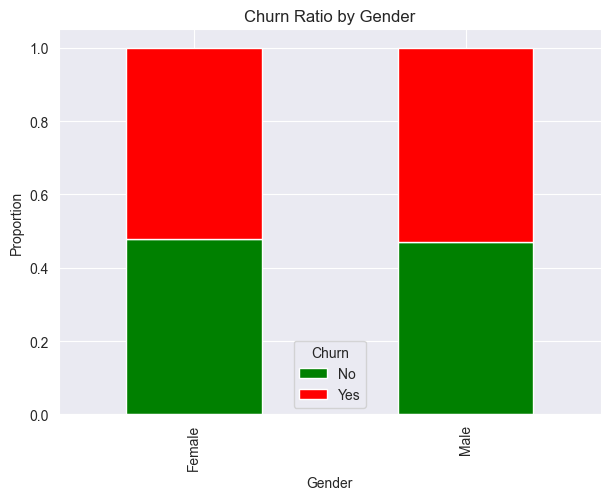

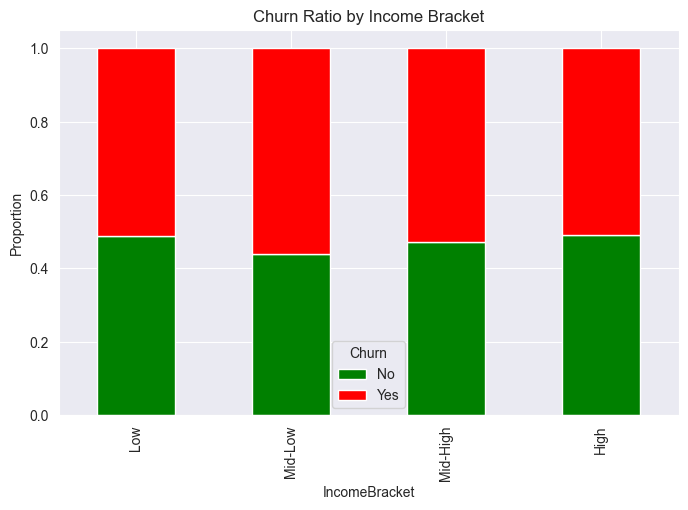

In [19]:
churn_by_gender = df.groupby("Gender")["Churn"].value_counts(normalize=True).unstack()
churn_by_income = df.groupby("IncomeBracket")["Churn"].value_counts(normalize=True).unstack()
# Plot churn by gender
churn_by_gender.plot(kind="bar", stacked=True, figsize=(7,5), color=["green","red"])
plt.title("Churn Ratio by Gender")
plt.ylabel("Proportion")
plt.show()
churn_by_income.plot(kind="bar", stacked=True, figsize=(8,5), color=["green","red"])
plt.title("Churn Ratio by Income Bracket")
plt.ylabel("Proportion")
plt.show()

In [20]:
customer_col = "CustomerID"
date_col = "TransactionDate"
amount_col = "PurchaseAmount"

# Convert date column to datetime
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

In [21]:
snapshot_date = df[date_col].max() + pd.Timedelta(days=1)

rfm = df.groupby(customer_col).agg({
    date_col: lambda x: (snapshot_date - x.max()).days,   # Recency
    customer_col: "count",                               # Frequency (# transactions)
    amount_col: "sum"                                    # Monetary (total spent)
})

rfm.rename(columns={date_col: "Recency", customer_col: "Frequency", amount_col: "Monetary"}, inplace=True)
print(rfm.head())

            Recency  Frequency  Monetary
CustomerID                              
CUST0001        468          1   3379.85
CUST0002        730          1   1233.27
CUST0003        222          1   1293.50
CUST0004        580          1   1599.63
CUST0005         14          1    412.06


In [22]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

# Cluster profile
cluster_profile = rfm.groupby("Cluster").agg({
    "Recency": ["mean", "median"],
    "Frequency": ["mean", "median"],
    "Monetary": ["mean", "median", "sum", "count"]
})
print(cluster_profile)

            Recency        Frequency            Monetary                      \
               mean median      mean median         mean   median        sum   
Cluster                                                                        
0        180.953668  182.0       1.0    1.0  3631.989768  3617.87  940685.35   
1        164.724696  153.0       1.0    1.0  1268.500324  1259.90  313319.58   
2        543.019608  539.0       1.0    1.0  1381.172784  1399.52  352199.06   
3        544.142259  534.0       1.0    1.0  3870.016778  3953.03  924934.01   

               
        count  
Cluster        
0         259  
1         247  
2         255  
3         239  


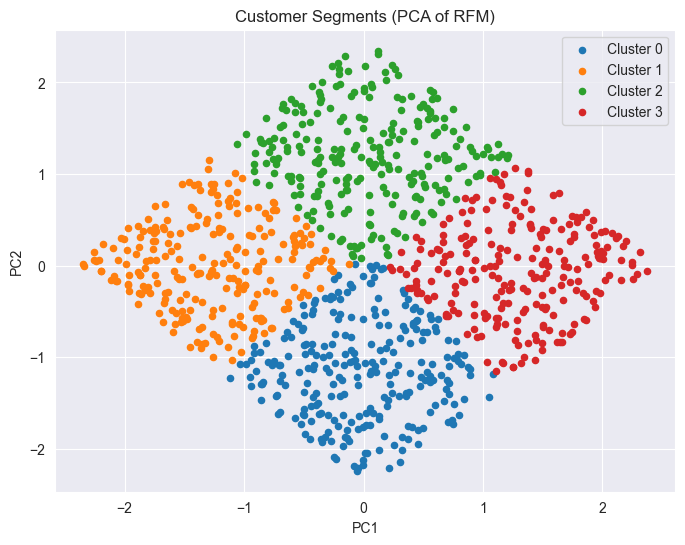

In [23]:
pca = PCA(n_components=2, random_state=42)
rfm_pca = pca.fit_transform(rfm_scaled)
rfm_plot = pd.DataFrame(rfm_pca, columns=["PC1","PC2"], index=rfm.index)
rfm_plot["Cluster"] = rfm["Cluster"].values

plt.figure(figsize=(8,6))
for cl in sorted(rfm_plot["Cluster"].unique()):
    subset = rfm_plot[rfm_plot["Cluster"]==cl]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Cluster {cl}", s=20)
plt.title("Customer Segments (PCA of RFM)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

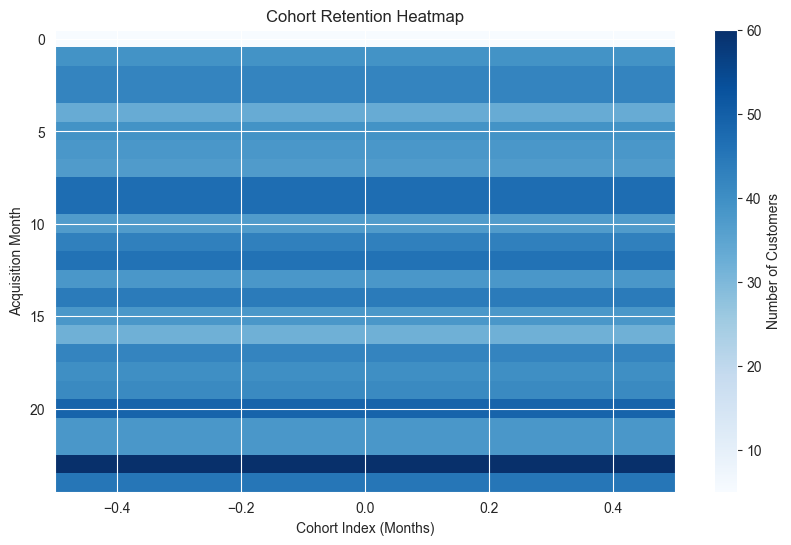

In [24]:
df["CohortMonth"] = df[date_col].dt.to_period("M")
df["AcqMonth"] = df.groupby(customer_col)[date_col].transform("min").dt.to_period("M")
df["CohortIndex"] = (df["CohortMonth"].dt.year - df["AcqMonth"].dt.year) * 12 + \
                    (df["CohortMonth"].dt.month - df["AcqMonth"].dt.month) + 1

cohort_data = df.groupby(["AcqMonth","CohortIndex"])[customer_col].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index="AcqMonth", columns="CohortIndex", values=customer_col)

plt.figure(figsize=(10,6))
plt.imshow(cohort_pivot, cmap="Blues", aspect="auto")
plt.title("Cohort Retention Heatmap")
plt.xlabel("Cohort Index (Months)")
plt.ylabel("Acquisition Month")
plt.colorbar(label="Number of Customers")
plt.show()


In [25]:
rfm["AvgOrderValue"] = rfm["Monetary"] / rfm["Frequency"]
rfm["CLV_Estimate"] = rfm["AvgOrderValue"] * rfm["Frequency"]
print(rfm[["Monetary","Frequency","AvgOrderValue","CLV_Estimate","Cluster"]].head())


            Monetary  Frequency  AvgOrderValue  CLV_Estimate  Cluster
CustomerID                                                           
CUST0001     3379.85          1        3379.85       3379.85        3
CUST0002     1233.27          1        1233.27       1233.27        2
CUST0003     1293.50          1        1293.50       1293.50        1
CUST0004     1599.63          1        1599.63       1599.63        2
CUST0005      412.06          1         412.06        412.06        1


In [26]:
basket = df.groupby([customer_col,"Region"])["PurchaseAmount"].sum().unstack().fillna(0)
basket_sets = basket.applymap(lambda x: 1 if x>0 else 0)

frequent_items = apriori(basket_sets, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_items, metric="lift", min_threshold=1)
print(rules.head())


Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []


C:\Users\Asus\AppData\Local\Temp\ipykernel_9060\1884201625.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(lambda x: 1 if x>0 else 0)
C:\Users\Asus\Desktop\upes\clgwork\5th SEM\DataVisualization_sem5\.venv\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [27]:
rfm.to_csv("rfm_with_clusters.csv")
cluster_profile.to_csv("cluster_profile.csv")
rules.to_csv("market_basket_rules.csv")